1. Import the library
2. Read the xlsx file in

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.optimize import curve_fit

file_path = 'C:/Users/凡/Desktop/project/durham_mds/data/PDNTBA pKa scans.xlsx'
sheet_name='pdntba20mmscan2'

df_new = pd.read_excel(file_path,sheet_name=sheet_name, engine='openpyxl')
df_new = df_new[1:]

Preprocess the data:
1. Remove the empty columns
2. Rename the columns

In [2]:
# Remove any completely empty columns
df_new = df_new.dropna(axis=1, how='all')

# Naming columns based on the header content directly
new_columns = []
for i in range(0, len(df_new.columns), 2):
    base_name = df_new.columns[i].strip()  # Use the base name directly from headers
    new_columns.extend([
        f"{base_name}_Wavelength",
        f"{base_name}_Absorbance"
    ])
df_new.columns = new_columns

# Optionally, you can clean the data by converting all to numeric and handling NaNs
for col in df_new.columns:
    df_new[col] = pd.to_numeric(df_new[col], errors='coerce')

# Display the renamed DataFrame to verify correct column naming
print("\nRenamed DataFrame:")
print(df_new.head())


Renamed DataFrame:
   20 mm hcl_Wavelength  20 mm hcl_Absorbance  10 mm hcl_Wavelength  \
1            600.043518              0.034357            600.043518   
2            599.895508              0.034461            599.895508   
3            599.599487              0.034452            599.599487   
4            599.451477              0.034552            599.451477   
5            599.303467              0.034563            599.303467   

   10 mm hcl_Absorbance  30 mm hcl_Wavelength  30 mm hcl_Absorbance  \
1              0.034332            600.043518              0.034252   
2              0.034342            599.895508              0.034253   
3              0.034428            599.599487              0.034264   
4              0.034513            599.451477              0.034053   
5              0.034170            599.303467              0.034154   

   60 mm hcl_Wavelength  60 mm hcl_Absorbance  40 mm hcl_Wavelength  \
1            600.043518              0.037046          

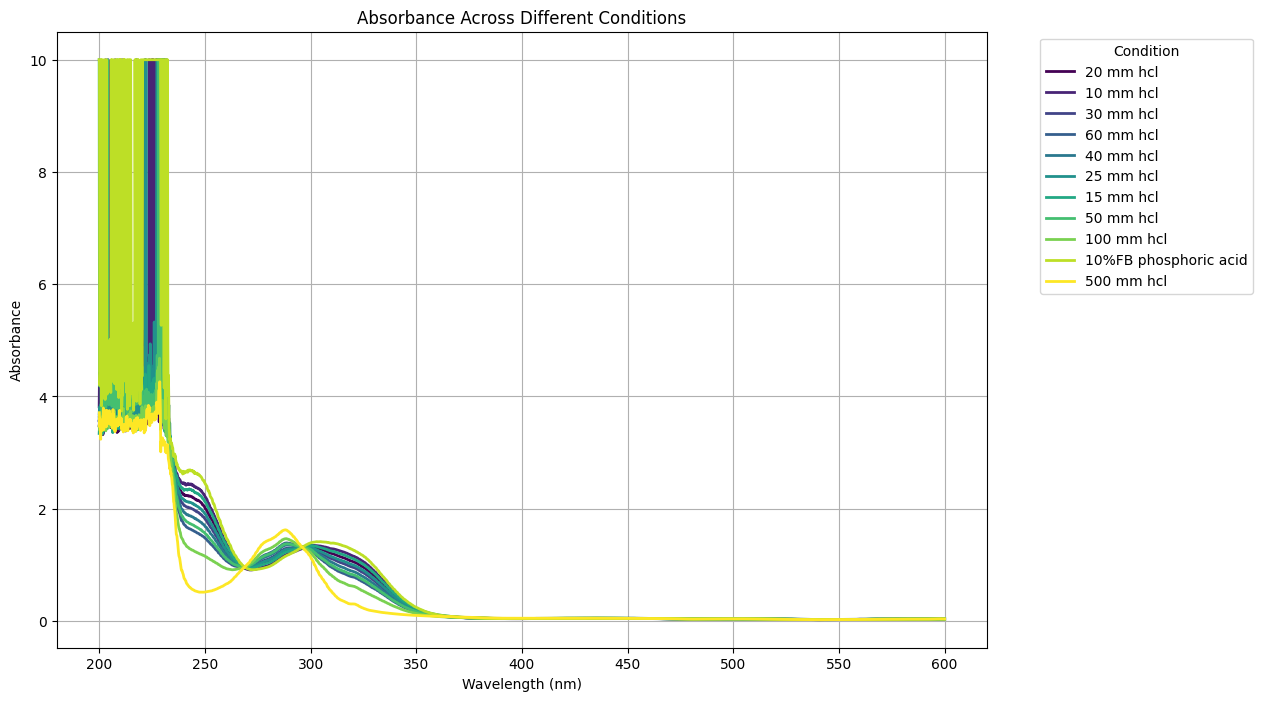

In [3]:
# Set up the figure
plt.figure(figsize=(12, 8))

# Color cycle for clarity
colors = plt.cm.viridis(np.linspace(0, 1, len(df_new.columns) // 2))

# Loop through each column to plot
for i, col in enumerate(df_new.columns):
    if 'Absorbance' in col:
        label = col.replace('_Absorbance', '')
        wavelength_col = f'{label}_Wavelength'
        if wavelength_col in df_new.columns:
            # Assign a unique color and make line style different for visibility
            plt.plot(df_new[wavelength_col], df_new[col], label=label, color=colors[i // 2], linestyle='-', linewidth=2)

plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance')
plt.title('Absorbance Across Different Conditions')
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


Filter the data:
1. Only the wavelength higher than 235 nm
2. Exclude 500 mm hcl and 10%FB phosphoric acid. SInce they seem to be the baseline
3. Exclude 60 mm hcl in this case. Since it has different wavelength axis, if included the variance will be hard to compare. If have to excluded, have to be transformed into the same wavelength axis

In [4]:
# Filter each wavelength and its corresponding absorbance only if wavelength is greater than 235
for col in df_new.columns:
    if 'Wavelength' in col:
        absorbance_col = col.replace('Wavelength', 'Absorbance')
        # Mask to apply
        mask = df_new[col] > 235
        
        # Apply mask
        df_new.loc[~mask, [col, absorbance_col]] = None
df_filtered = df_new.drop(columns=['500 mm hcl_Wavelength', '500 mm hcl_Absorbance', '60 mm hcl_Wavelength', '60 mm hcl_Absorbance', '10%FB phosphoric acid_Absorbance', '10%FB phosphoric acid_Wavelength'], errors='ignore')

Print all the colour on the same graph

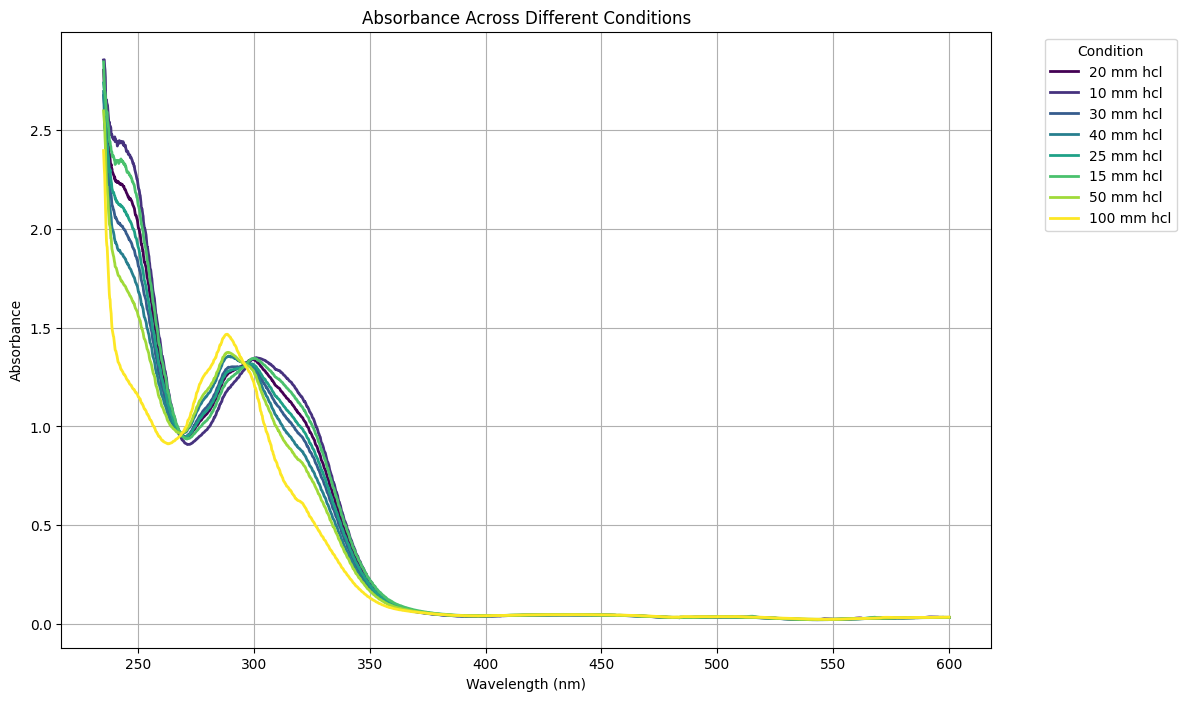

In [5]:
# Set up the figure
plt.figure(figsize=(12, 8))

# Color cycle for clarity
colors = plt.cm.viridis(np.linspace(0, 1, len(df_filtered.columns) // 2))

# Loop through each column to plot
for i, col in enumerate(df_filtered.columns):
    if 'Absorbance' in col:
        label = col.replace('_Absorbance', '')
        wavelength_col = f'{label}_Wavelength'
        if wavelength_col in df_filtered.columns:
            # Assign a unique color and make line style different for visibility
            plt.plot(df_filtered[wavelength_col], df_filtered[col], label=label, color=colors[i // 2], linestyle='-', linewidth=2)

plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance')
plt.title('Absorbance Across Different Conditions')
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


Apply the peak finding algorithm on the dataset

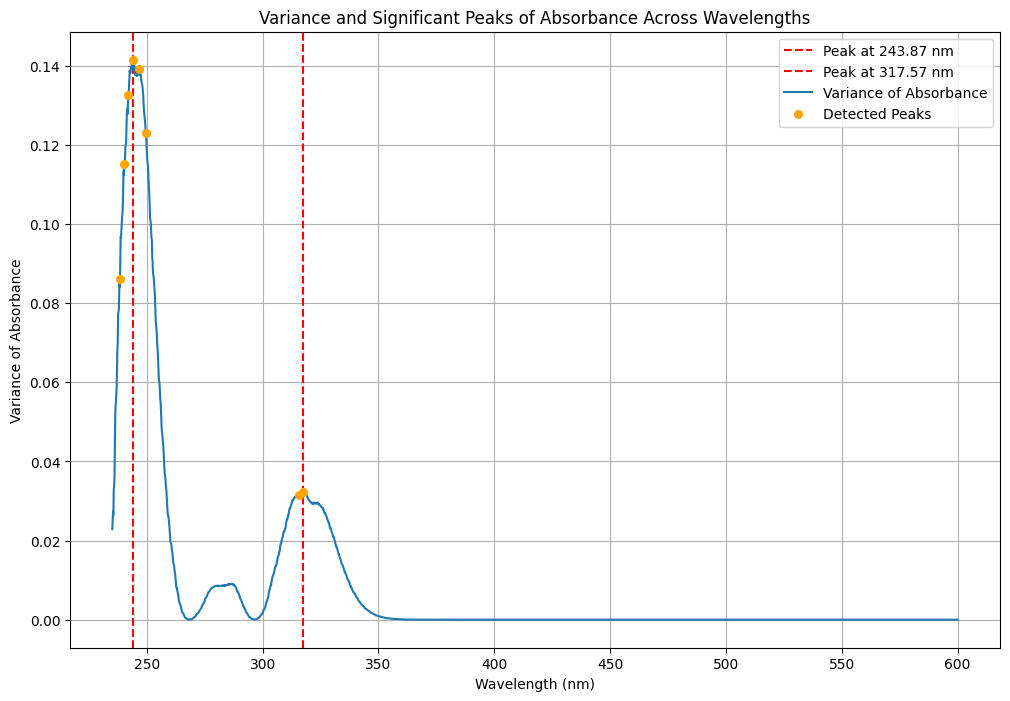

In [6]:
# Step 1: Reshape the DataFrame to have one row per wavelength and one column per condition's absorbance
# Create a new DataFrame with wavelength as index and absorbance values across conditions
data = {
    'Wavelength': np.repeat(df_filtered['20 mm hcl_Wavelength'].values, df_filtered.shape[1] // 2),
    'Absorbance': df_filtered.filter(like='Absorbance').values.flatten()
}
df_reshaped = pd.DataFrame(data)

# Group by Wavelength and calculate the mean absorbance if needed or directly variance
grouped = df_reshaped.groupby('Wavelength')['Absorbance'].var()

# Step 2: Find peaks in the variance
from scipy.signal import find_peaks
peaks, properties = find_peaks(grouped.values, height=np.percentile(grouped.values, 92), distance=10)

# Proceed only if peaks are found
if len(peaks) > 0:
    # Prepare the data for clustering
    peak_wavelengths = grouped.index[peaks].to_numpy()
    peak_variances = grouped.values[peaks]

    # Reshape peak wavelengths for clustering
    peak_wavelengths_array = peak_wavelengths.reshape(-1, 1)
    clustering = DBSCAN(eps=5, min_samples=1).fit(peak_wavelengths_array)
    labels = clustering.labels_

    # Select the most significant peak within each cluster
    final_wavelengths = []
    for label in np.unique(labels):
        cluster_indices = np.where(labels == label)[0]
        cluster_peaks = peak_wavelengths[cluster_indices]
        cluster_variances = peak_variances[cluster_indices]
        most_significant_peak = cluster_peaks[np.argmax(cluster_variances)]
        final_wavelengths.append(most_significant_peak)

    # Plotting the spectral difference with significant wavelengths
    plt.figure(figsize=(12, 8))
    for wavelength in final_wavelengths:
        plt.axvline(x=wavelength, color='red', linestyle='--', label=f'Peak at {wavelength:.2f} nm')

    plt.plot(grouped.index, grouped.values, label='Variance of Absorbance')
    plt.scatter(grouped.index[peaks], grouped.values[peaks], color='orange', s=30, zorder=3, label='Detected Peaks')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Variance of Absorbance')
    plt.title('Variance and Significant Peaks of Absorbance Across Wavelengths')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No peaks were detected. Consider adjusting the height and distance parameters.")

Fit the curve

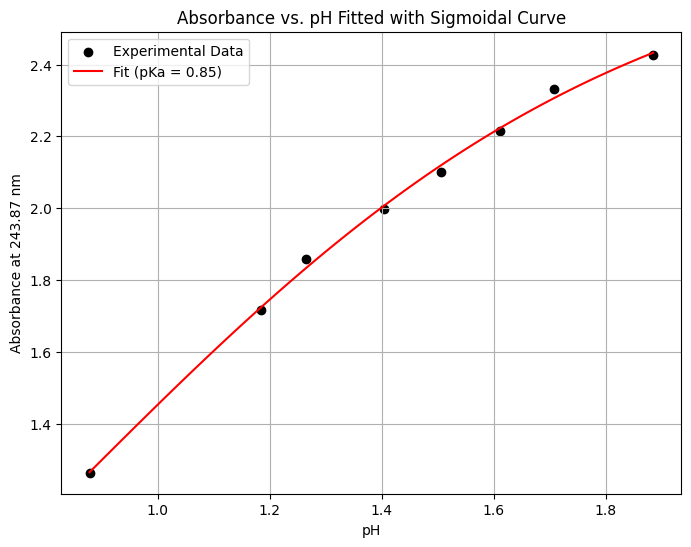

Determined pKa value: 0.85


In [7]:
# Assuming you have a mapping of pH values to conditions
ph_data = {
    '10 mm hcl': 1.885,
    '15 mm hcl': 1.707,
    '20 mm hcl': 1.611,
    '25 mm hcl': 1.506,
    '30 mm hcl': 1.404,
    '40 mm hcl': 1.264,
    '50 mm hcl': 1.184,
    '100 mm hcl': 0.878,
}

# Define the sigmoidal function
def sigmoid(pH, pKa, a, b):
    return b + (a / (1 + np.exp((pKa - pH) * 2)))

# Prepare the data for fitting
absorbance_values = []
pH_values = []

# Assuming the nearest to 243.87 nm is consistently formatted across all conditions
target_wavelength = 243.87
for condition, pH in ph_data.items():
    # Generate the column name for each condition's absorbance
    column_name = f"{condition}_Absorbance"  # Adjust based on your actual column naming convention
    # Find the nearest wavelength index
    closest_index = np.abs(df_filtered[f'{condition}_Wavelength'] - target_wavelength).idxmin()
    # Get the absorbance at the closest wavelength
    absorbance_values.append(df_filtered.loc[closest_index, column_name])
    pH_values.append(pH)

# Convert lists to numpy arrays for fitting
absorbance_values = np.array(absorbance_values)
pH_values = np.array(pH_values)

# Fit the sigmoidal curve
p0 = [6.5, max(absorbance_values) - min(absorbance_values), min(absorbance_values)]
popt, pcov = curve_fit(sigmoid, pH_values, absorbance_values, p0, maxfev=5000)
pKa_value = popt[0]

# Generate pH range for plotting
pH_fit = np.linspace(min(pH_values), max(pH_values), 100)
fit_absorbance = sigmoid(pH_fit, *popt)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(pH_values, absorbance_values, color='black', label='Experimental Data')
plt.plot(pH_fit, fit_absorbance, label=f'Fit (pKa = {pKa_value:.2f})', color='red')
plt.xlabel('pH')
plt.ylabel('Absorbance at 243.87 nm')
plt.title('Absorbance vs. pH Fitted with Sigmoidal Curve')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

print(f'Determined pKa value: {pKa_value:.2f}')